In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib.ticker import LogLocator, FormatStrFormatter
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

## importance sampling during training

Below is an example implementation of a PINN in PyTorch that incorporates self-adaptive importance sampling similar to the paper. In this simplified example, we solve a one-dimensional PDE (here, we use a toy example u_xx +sin(πx)=0) by training on collocation points that are periodically updated by sampling more densely in regions where the PDE residual is high.

You can adjust the PDE, network architecture, and hyperparameters as needed.

### Sampling Strategy:

Initially, collocation points are sampled uniformly.
In the function importance_sampling, the model is evaluated on a dense grid over the domain. The absolute value of the residual (plus a small epsilon) forms a weight distribution, and new collocation points are drawn according to this distribution. This mimics the failure-informed sampling by focusing training on regions where the PDE is not well satisfied.
### Training Loop:
The model trains for a set number of epochs. Every few epochs (here, every 1000 epochs), the collocation points are updated using the importance sampling procedure.

In [ ]:
plt.figure(figsize=(12, 6))
# Plot g_weights
plt.subplot(1, 2, 1)
plt.plot(G_weights[:20], 'o', label='g_weights', color='blue')
plt.title('g_weights')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.grid(True)
plt.legend()

# Plot g_vals
plt.subplot(1, 2, 2)
plt.plot(-abs(G_vals[:20]), 'o-', label='g_vals', color='orange')
plt.title('g_vals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# def inspect_activations(model, x):
#     """
#     Feeds x through model.net and prints min/max pre-activations for each Linear layer.
#     x should be shape (1,6).
#     """
#     activ = x
#     layer_i = 0
#     for layer in model.net:
#         if isinstance(layer, nn.Linear):
#             z = layer(activ)
#             print(f"Layer {layer_i} pre-act:  min {z.min().item():.2f}, max {z.max().item():.2f}")
#             activ = z
#             layer_i += 1
#         else:  # nn.Tanh (or any activation)
#             activ = layer(activ)

# # Reconstruct each input as a (1,1) Tensor
# τ_test  = torch.tensor([[0.0]])  # normalized time = 0
# m_z_val = (4.0 - m_mean) / m_std
# mu_z_val = (mu_mean - mu_mean) / mu_std  # e.g. 0 at mean
# k_z_val  = 0.0
# y0_z_val = 0.0
# v0_z_val = (4.0 - v0_mean) / v0_std

# # Wrap each in a 1×1 Tensor
# m_z   = torch.tensor([[m_z_val]],   dtype=torch.float32)
# mu_z  = torch.tensor([[mu_z_val]],  dtype=torch.float32)
# k_z   = torch.tensor([[k_z_val]],   dtype=torch.float32)
# y0_z  = torch.tensor([[y0_z_val]],  dtype=torch.float32)
# v0_z  = torch.tensor([[v0_z_val]],  dtype=torch.float32)

# # Now concatenate along dim=1 to get shape (1,6)
# x_test = torch.cat([τ_test, m_z, mu_z, k_z, y0_z, v0_z], dim=1)

# # And inspect all layers’ pre‐activations:
# inspect_activations(PINN_model, x_test)

In [ ]:
import numpy as np

def sample_time_points(T, N, r):
    """
    Sample N time points from a truncated exponential distribution over [0, T].

    Parameters:
    - T: Total time duration.
    - N: Number of time points to sample.
    - r: Rate parameter of the exponential distribution.

    Returns:
    - Array of sampled time points.
    """
    if r == 0:
        # Uniform sampling
        return np.linspace(0, T, N)
    else:
        # Inverse transform sampling
        u = np.random.uniform(0, 1, N)
        return -np.log(1 - u * (1 - np.exp(-r * T))) / r

https://arxiv.org/abs/2404.18780

# XPINN

629524


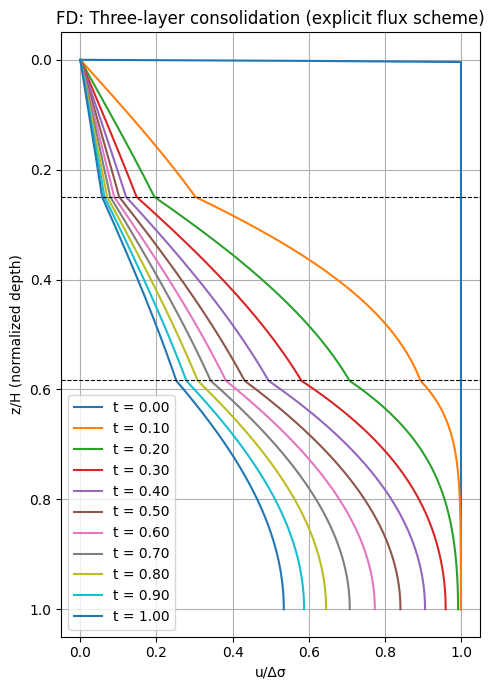

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# === 1) Physical parameters and nondimensional collapse factor α = cv·T_phys/H_phys² ===
k1_phys = 0.01        # permeability in layer 1 [m/year]
k2_phys = 0.001       # permeability in layer 2 [m/year]
k3_phys = 4e-5       # permeability in layer 3 [m/year]
mv1      = 7e-5           # compressibility [m²/kN]
mv2      = 2e-5           # compressibility [m²/kN]
mv3      = 2e-6           # compressibility [m²/kN]
yw      = 9.81           # unit weight [kN/m³]
H_phys  = 12.0           # total thickness [m]
T_phys  = 10     # consolidation time span [years]

cv1 = k1_phys / (mv1 * yw)
cv2 = k2_phys / (mv2 * yw)
cv3 = k3_phys / (mv3 * yw)
alpha1 = cv1 * T_phys / H_phys**2
alpha2 = cv2 * T_phys / H_phys**2
alpha3 = cv3 * T_phys / H_phys**2

# === 2) Spatial grid (normalized z ∈ [0,1]) ===
Nz   = 500
z_nd = np.linspace(0, 1, Nz)
dz   = z_nd[1] - z_nd[0]

# define layer boundaries at 1/3 and 2/3
z1, z2 = 3/12, 7/12
alpha = np.zeros(Nz)
alpha[z_nd <= z1]        = alpha1
alpha[(z_nd > z1) & (z_nd <= z2)] = alpha2
alpha[z_nd > z2]         = alpha3

# === 3) Precompute interface values (harmonic average) ===
alpha_half = np.zeros(Nz - 1)
alpha_half[:] = 2 * alpha[:-1] * alpha[1:] / (alpha[:-1] + alpha[1:])

# === 4) Time stepping parameters (explicit scheme stability) ===
dt = 0.4 * dz**2 / alpha.max()   # CFL-limited time step
Nt = int(np.ceil(1.0 / dt)) + 1  # nondimensional end time T_nd = 1.0
print(Nt)

# times at which to record solution
record_times = [0.0, 0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7,.8,.9,1.0]
record_steps = {int(t / dt): t for t in record_times}

# === 5) Initialize u (u/Δσ), BC: u(0)=0, ∂u/∂z(1)=0 ===
u = np.ones(Nz)                 # initial u = 1 everywhere
u[0] = 0.0                      # drained top: u=0
u[-1] = u[-2]                   # impermeable bottom: du/dz=0

# storage
u_history = {}

# === 6) Time march using flux form ===
for n in range(Nt):
    u_new = u.copy()
    
    # compute fluxes F[i+1/2] = alpha_{i+1/2} * (u[i+1] - u[i]) / dz
    F = alpha_half * (u[1:] - u[:-1]) / dz

    # update interior points via flux divergence
    u_new[1:-1] = u[1:-1] + (dt / dz) * (F[1:] - F[:-1])

    # reapply BCs
    u_new[0]  = 0.0
    u_new[-1] = u_new[-2]

    u = u_new

    # record if on our list
    if n in record_steps:
        u_history[record_steps[n]] = u.copy()

# === 7) Plot results ===
plt.figure(figsize=(5,7))
for t in record_times:
    plt.plot(u_history[t], z_nd, label=f't = {t:.2f}')
# mark layer interfaces
plt.axhline(z1, color='k', linestyle='--', linewidth=0.8)
plt.axhline(z2, color='k', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.xlabel('u/Δσ')
plt.ylabel('z/H (normalized depth)')
plt.title('FD: Three-layer consolidation (explicit flux scheme)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
